# Analyzing the effect of Interferon Beta stimulation on PBMCs

Dataset is from demuxlet: https://www.ncbi.nlm.nih.gov/pubmed/29227470.

This notebook is meant to serve as a tutorial for using scMeMo, initially designed for members of the Ye Lab. This tutorial walks you through a very small analysis of the interferon dataset, limited to a few thousand genes and 2 cell types.

### Import some helpful packages

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import imp
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
np.set_printoptions(precision=None, suppress=True)

In [5]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### Import scMeMo

Eventually, we will have scMeMo available through pip and conda. Until then, please use the github version.

In [6]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/scmemo')
import mme, utils, sparse_array

### Load the data

In general, I suggest to use the full dataset (the one with 30k genes). Of course, many of these genes will be all zeros, etc. scMeMo is designed to take in sparse matrices, since almost all the operations are performed directly on the count data.

This dataset has 29065 cells and 35635 genes.

In [7]:
data_path = '/data/mincheol/parameter_estimation/interferon_data/20200412/'
adata = sc.read(data_path + 'interferon.h5ad')
adata = adata[(adata.obs.multiplets == 'singlet') & (adata.obs.cell != 'nan'), :].copy()

In [8]:
adata_highcount = sc.read(data_path + 'interferon_highcount.raw.h5ad')
adata_highcount.obs['cell_type'] = (adata_highcount.obs['cell'].astype(str) + ' - ' + adata_highcount.obs['stim'].astype(str)).astype('category')
gene_list = adata_highcount.var.index.tolist()

In [9]:
%matplotlib inline

... storing 'ind' as categorical
... storing 'stim' as categorical
... storing 'cluster' as categorical
... storing 'cell' as categorical
... storing 'multiplets' as categorical


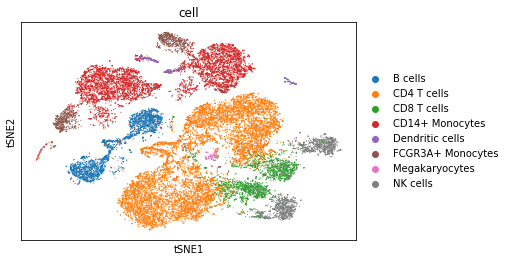

In [10]:
sc.pl.tsne(adata, color='cell')

### Prepare the AnnData object for scMeMo

scMeMo takes in an anndata object with up to three different features of each cell, which are columns in the `adata.obs` DataFrame. To explain the vocabulary further:
- `covariate`: this is the variable that the hypothesis test is performed under. In this case, this column can be either `ctrl` or `stim`. The column name here is `stim`
-`replicate`: In the Ye Lab, this is most likely going to be individuals. These are ways to naturally group the cells to be considered separately, and different from batches. The column name here is `ind`
-`batch`: we all know what batches are. There are no batches in this dataset.
-`subsection`: this is the labels that will divide up the hypothesis test. In this case, cell types will comprise the different `subsections` to study the effect of IFN-B. Here the column name is `cell`

scMeMo also expects the `anndata` object to be composed of a sparse matrix of an integer type.

In [11]:
adata.X = adata.X.astype(np.int64)

In [12]:
adata.obs.sample(5)

,tsne1,tsne2,ind,stim,cluster,cell,multiplets
index,,,,,,,
GTTCATACAAAGTG-1,12.494716,8.776213,1016,stim,6,CD4 T cells,singlet
CCACGGGATGCAAC-1,7.078447,37.918229,101,stim,8,CD14+ Monocytes,singlet
CTGAATCTTCTTTG-1,15.263670,-24.312737,1015,ctrl,10,CD8 T cells,singlet
GCGAGAGAGCAAGG-1,18.792116,28.235307,1015,stim,8,CD14+ Monocytes,singlet
GCTACAGAGAGAGC-1,39.379485,-4.565459,1488,stim,7,NK cells,singlet


### Provide an estimate for $\mathbb{E}[q]$

The value you should provide is the product of the capture efficiency (generally known for each technology) and the sequencing capture rate. The latter number is generally estimated from the alignment tool such as cell ranger. In this example, we used a 10X v1 kit (capture rate of around 0.08) and sequenced until about 90% of the transcripts are recovered. For this tutorial, we will use $\mathbb{E}[q] = 0.7$

For 10X: https://kb.10xgenomics.com/hc/en-us/articles/360001539051-What-fraction-of-mRNA-transcripts-are-captured-per-cell-

In [13]:
q = 0.07

### Instantiate the estimator

To be clear:
- `adata` is the `anndata` object
- `covariate_label` is the column name specifying the `covariate` in the `adata.obs` DataFrame.
- `replicate_label` is the column name specifying the `replicate` in the `adata.obs` DataFrame.
- `batch_label` is the column name specifying the `batch` in the `adata.obs` DataFrame.
- `subsection_label` is the column name specifying the `subsection` in the `adata.obs` DataFrame.
- `num_permute` is the number of bootstrap iterations. 
- `covariate_converter` codes the string representation of the covariates into numerical levels. If the variable is ordinal (such as genetics), we could code for example `{'AA':0, 'Aa':1, 'aa':2}`
- `use_hat_matrix` refers to precomputing the hat matrix for getting the estimated/bootstrapped effect sizes. If `# of replicates` x `# number of batches` x `# of levels in the covariate` is less than ~50 or so, this could provide a significant speed up. However, if there are many individuals, it would take a large amount of memory.

Initialization could take up to half a minute to instantiate empty sparse matrices to hold information later on.

In [23]:
%%time
imp.reload(utils)
imp.reload(sparse_array)
imp.reload(mme)

estimator = mme.SingleCellEstimator(
    adata=adata,
    covariate_label='stim',
    replicate_label=None,
    batch_label=None,
    subsection_label='cell',
    num_permute=10000,
    covariate_converter={'ctrl':0, 'stim':1},
    q=q,
    smooth=False,
    use_hat_matrix=True)

CPU times: user 2.72 s, sys: 180 ms, total: 2.9 s
Wall time: 2.91 s


### Estimate $\mathbb{E}[q^2]$ from the data

We can qualitatively assess the quality of the estimate visually by plotting the log mean versus the log CV (coefficient of variation) using all cells. When `plot_cv_mean_curve` is called, you should see the red line hugging the convex portion of the scatterplot. For highly expressed genes (on the left end of the plot), the effect of the variance of $q$ becomes more prominent.

If this curve looks weird for some reason, or does not hug the bottom of the scatter plot, try adjusting the `k` parameter to include/exclude more genes.

E[q^2] falls in [0.00490, 0.00656014], with the current estimate of 0.00583650. Estimated with 5939 genes that have max expr > 5.


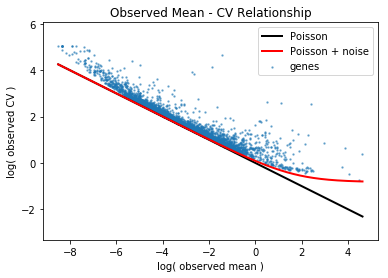

In [24]:
estimator.estimate_q_sq(k=5)
estimator.plot_cv_mean_curve()

### Define some genes to look at for one dimensional analysis

Here, we will simply take the 2000 genes that are expressed in the largest number of cells. In general, particularly for the variability/correlation analysis, genes that are very lowly expressed (>90% of cells have 0's) will not yield accurate estimates.

In [25]:
adata.var['n_cells'] = (adata.X > 0).sum(axis=0).A1
adata.var.sample(3)

,gene_ids,n_cells
index,,
HLA-DRA-6,ENSG00000228987,0
TICAM2,ENSG00000243414,11
PINX1,ENSG00000254093,440


In [26]:
# gene_list = adata.var.sort_values('n_cells', ascending=False).head(2000).index.tolist()
# print(gene_list[1000:1010])

### Get point estimates for the moments for each group.

scMeMo defines groups of cells by covariate/replicate/batch/subsection (much like how we make pseudobulks in a more conventional analysis. For each of these groups, we get a point estimate of mean and variability. 

In [27]:
estimator.compute_observed_moments(gene_list)
estimator.estimate_1d_parameters(gene_list)

/home/ssm-user/Github/scrna-parameter-estimation/scmemo/mme.py:199: RuntimeWarning: divide by zero encountered in log
  np.log(estimated_mean),
/home/ssm-user/Github/scrna-parameter-estimation/scmemo/mme.py:200: RuntimeWarning: divide by zero encountered in log
  np.log(estimated_var),
/home/ssm-user/Github/scrna-parameter-estimation/scmemo/utils.py:199: RuntimeWarning: invalid value encountered in add
  fitted += fit[i]*x**(fit.shape[0]-i-1)
/home/ssm-user/Github/scrna-parameter-estimation/scmemo/mme.py:217: RuntimeWarning: divide by zero encountered in log
  self.parameters[group]['log_mean'][gene_idxs] = np.log(self.estimated_central_moments[group]['first'][gene_idxs])


### Set up the hypothesis testing

We will focus on the CD14+ Monocytes and CD4 T cells. This step defines the subsections that you would like to perform hypothesis testing of the covariate for, and the list can include as many subsections as you want. 

In [28]:
estimator.setup_hypothesis_testing(subsections=['CD14+ Monocytes'])

### Perform hypothesis testing for mean and variability

First we compute the effect sizes using the given dataset. Then, we compute the significance levels via the bootstrap.

In [ ]:
%%time
estimator.compute_effect_sizes_1d(gene_list)
estimator.compute_confidence_intervals_1d(gene_list)

### Get the hypothesis test results

All of the results for hypothesis testing are stored in the `estimator.hypothesis_test_result` dictionary. This is an example of how one would extract the result for the 1D test.

Eventually I plan to provide wrapper functions for these to increase convenience.

In [68]:
# Grab the idxs to retrieve from the sparse data structures
gene_idxs = estimator._get_gene_idxs(gene_list)

In [486]:
test_1d_result = pd.DataFrame()
test_1d_result['gene'] = adata.var.iloc[gene_idxs, :].index.tolist()
for col in ['de_effect_size', 'de_pval', 'de_fdr', 'dv_effect_size', 'dv_pval', 'dv_fdr']:
    test_1d_result[col] = estimator.hypothesis_test_result['CD14+ Monocytes'][col][gene_idxs]

### Explore the 1D result a bit

Use standard operations to explore the data, such as looking at upregulated genes that were either increased or decreased in variability.

Here, we use FDR < 0.1 for DV and FDR < 0.05 for DE.

Many of the genes that are "canonically" associated with Type I interferon are upregulated with decreased variability, indicating that this process is highly uniform across different cells.

In [498]:
# Upregulated genes that decreased in variability
test_1d_result.query('dv_fdr < 0.1 & de_fdr < 0.05 & de_effect_size > 0 & dv_effect_size < 0').sort_values('dv_effect_size').head(8)

,gene,de_effect_size,de_pval,de_fdr,dv_effect_size,dv_pval,dv_fdr
119,ISG15,4.893924,6.168105e-07,2.267686e-06,-6.722795,5.177356e-06,0.000279
458,CXCL10,6.167340,1.140854e-07,8.749120e-07,-4.661539,2.999700e-03,0.031679
647,APOBEC3A,3.901172,2.862087e-08,4.240129e-07,-3.400285,3.286121e-06,0.000273
890,IDO1,4.095276,2.147068e-07,1.262981e-06,-3.160524,1.757178e-04,0.002875
146,IFI6,3.099739,4.657890e-10,7.165984e-08,-2.965109,5.608876e-05,0.001116
612,TNFSF13B,3.578907,3.526636e-05,5.642617e-05,-2.861993,5.791183e-04,0.008316
221,IFITM2,2.973849,8.614105e-07,2.769809e-06,-2.494188,2.994171e-05,0.000687
565,CCL2,1.635130,4.715570e-07,1.916898e-06,-2.489128,4.288281e-07,0.000078


In [499]:
# Upregulated genes that increased in variability
test_1d_result.query('dv_fdr < 0.1 & de_fdr < 0.05 & de_effect_size > 0 & dv_effect_size > 0').sort_values('dv_effect_size', ascending=False).head(8)

,gene,de_effect_size,de_pval,de_fdr,dv_effect_size,dv_pval,dv_fdr
1982,NEXN,6.403522,1.994220e-07,1.200552e-06,4.905220,5.310503e-06,0.000279
1893,HSH2D,4.826347,8.819748e-09,2.989745e-07,3.001474,4.537960e-05,0.000953
1871,LGALS3BP,3.608416,2.130042e-08,3.670655e-07,2.877453,5.212048e-06,0.000279
1359,CD38,6.213120,2.385801e-09,1.445940e-07,2.555112,1.433642e-07,0.000048
1535,HES4,5.668182,8.853774e-08,7.665606e-07,2.260857,3.239795e-07,0.000072
1798,HERC6,4.120646,1.002546e-07,8.184050e-07,2.012484,2.354397e-04,0.003615
1440,PRF1,1.964011,2.767501e-07,1.461480e-06,1.797528,9.599040e-03,0.082585
501,FAM177A1,0.769603,5.719506e-08,6.020532e-07,1.414278,1.512934e-04,0.002517


In [502]:
# Downregulated genes that increased in variability
test_1d_result.query('dv_fdr < 0.1 & de_fdr < 0.05 & de_effect_size < 0 & dv_effect_size > 0').sort_values('dv_effect_size', ascending=False).head(8)

,gene,de_effect_size,de_pval,de_fdr,dv_effect_size,dv_pval,dv_fdr
1438,LSM2,-0.346625,1.999800e-03,2.654015e-03,1.967604,1.078855e-04,0.001841
786,IL8,-1.908357,2.933576e-05,4.743049e-05,1.875686,4.632939e-09,0.000005
147,RPL23,-1.096293,5.296212e-06,1.011693e-05,1.697884,1.205038e-05,0.000399
218,TIMP1,-0.535756,4.416870e-08,5.372411e-07,1.643236,4.621271e-06,0.000279
37,RPL26,-0.500796,7.917481e-07,2.642821e-06,1.547466,1.036916e-05,0.000376
28,RPL7,-0.902851,8.547373e-08,7.497696e-07,1.471561,2.987534e-07,0.000072
433,MARCKSL1,-1.249626,1.233062e-08,3.074634e-07,1.426609,1.358337e-05,0.000424
61,RPL6,-1.181856,2.656688e-07,1.435079e-06,1.415941,1.929226e-04,0.003081


### Get gene lists 2D hypothesis testing

As a small example, we will look at the effect of interferon on the correlation between known TFs and other genes. Particularly, we will look at STAT1 and STAT2 as the major mediators of the IFNB->JAK/STAT pathway.

We will take the previously analyzed 2k genes as potentially being implicated in the same regulatory circuit as the STATs.

Testing for correlation scales roughly similar to the 1D analysis, except that it scales with the number of **pairs** of genes. So in this case, we are testing 4000 "cases," since we are looking at 2 TFs.

In [71]:
gene_list_1 = ['STAT1', 'STAT2']
gene_list_2 = gene_list[-200:]
# gene_list_2 = ['IFIT1']

In [72]:
# Grab the idxs to retrieve from the sparse data structures
gene_idxs_1 = estimator._get_gene_idxs(gene_list_1)
gene_idxs_2 = estimator._get_gene_idxs(gene_list_2)

### Estimate the 2D parameters for the given genes

In [73]:
estimator.estimate_2d_parameters(gene_list_1, gene_list_2)

/home/ssm-user/Github/scrna-parameter-estimation/scmemo/mme.py:511: RuntimeWarning: invalid value encountered in true_divide
  estimated_corr = estimated_cov / np.sqrt(vars_1[:, np.newaxis]).dot(np.sqrt(vars_2[np.newaxis, :]))
/home/ssm-user/Github/scrna-parameter-estimation/scmemo/mme.py:511: RuntimeWarning: invalid value encountered in true_divide
  estimated_corr = estimated_cov / np.sqrt(vars_1[:, np.newaxis]).dot(np.sqrt(vars_2[np.newaxis, :]))
/home/ssm-user/Github/scrna-parameter-estimation/scmemo/mme.py:511: RuntimeWarning: invalid value encountered in true_divide
  estimated_corr = estimated_cov / np.sqrt(vars_1[:, np.newaxis]).dot(np.sqrt(vars_2[np.newaxis, :]))
/home/ssm-user/Github/scrna-parameter-estimation/scmemo/mme.py:511: RuntimeWarning: invalid value encountered in true_divide
  estimated_corr = estimated_cov / np.sqrt(vars_1[:, np.newaxis]).dot(np.sqrt(vars_2[np.newaxis, :]))
/home/ssm-user/Github/scrna-parameter-estimation/scmemo/mme.py:511: RuntimeWarning: invalid 

### Perform hypothesis testing for changes in correlation

In [74]:
estimator.compute_effect_sizes_2d(gene_list_1, gene_list_2)

In [75]:
%%time
estimator.compute_confidence_intervals_2d(gene_list_1, gene_list_2, verbose=True)

Computing the 0st/th gene pair of 400. 0.31655 seconds have passed.


/home/ssm-user/Github/scrna-parameter-estimation/scmemo/mme.py:872: RuntimeWarning: invalid value encountered in sqrt
  estimated_corrs[group] = cov / np.sqrt(estimated_vars_1[group]*estimated_vars_2[group])


Computing the 100st/th gene pair of 400. 8.76850 seconds have passed.
Computing the 200st/th gene pair of 400. 15.67330 seconds have passed.
Computing the 300st/th gene pair of 400. 21.39696 seconds have passed.
CPU times: user 25.3 s, sys: 511 ms, total: 25.8 s
Wall time: 25.8 s


In [81]:
dfs = []
for idx, tf in enumerate(['STAT1', 'STAT2']):
    test_2d_result = pd.DataFrame()
    test_2d_result['gene'] = gene_list_2
    test_2d_result['tf'] = tf

    for col in ['dc_effect_size', 'dc_pval', 'dc_fdr', 'dc_es_ci']:
        test_2d_result[col] = estimator.hypothesis_test_result['CD14+ Monocytes'][col][gene_idxs_1[:, np.newaxis], gene_idxs_2].toarray()[idx, :]
    dfs.append(test_2d_result)
test_2d_result = pd.concat(dfs)

In [82]:
def robust_hist(x):
    
    sns.distplot(x[np.isfinite(x)])

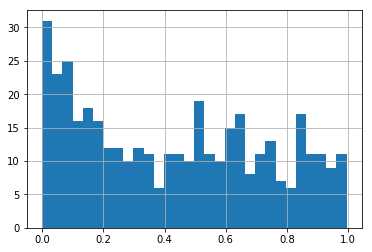

In [86]:
test_2d_result['dc_pval'].hist(bins=30)

In [83]:
test_2d_result.shape

(400, 6)

In [85]:
test_2d_result.query('gene == "MX1"')

,gene,tf,dc_effect_size,dc_pval,dc_fdr,dc_es_ci
189,MX1,STAT1,0.233168,0.034197,0.385961,0.105399
189,MX1,STAT2,-0.168212,0.066393,0.471420,0.142839


In [78]:
test_2d_result.to_csv('temp.csv', index=False)

In [53]:
test_2d_result.head(5)

,gene,tf,dc_effect_size,dc_pval,dc_fdr,dc_es_ci
0,ZNF428,STAT1,0.137961,0.259574,0.564624,0.148047
1,PLAUR,STAT1,-0.038660,0.719728,0.886816,0.091736
2,ZNF224,STAT1,0.234862,0.218378,0.513831,0.195835
3,ZNF226,STAT1,-0.017523,0.830317,0.908170,0.187504
4,PVRL2,STAT1,0.038537,0.692531,0.876621,0.114985


In [50]:
expression_values = []
ci = []
gene_idx = adata.var.index.tolist().index('PRMT2')
for group in estimator.hypothesis_test_result['CD14+ Monocytes']['groups']:
    expression_values.append([estimator.parameters[group]['corr'][gene_idxs_1[0], gene_idx]][0])
    ci.append([estimator.parameters_confidence_intervals[group]['corr'][gene_idxs_1[0], gene_idx]][0])
df = estimator.hypothesis_test_result['CD14+ Monocytes']['design_df']
df['expr'] = expression_values
df['ci'] = ci

In [40]:
df

,covariate,replicate,batch,constant,cell_count,expr,ci
0,0,default_rep,default_batch,1,2785,-0.003420,0.069275
1,1,default_rep,default_batch,1,2600,-0.039566,0.089976


In [130]:
np.sqrt(np.nan)

nan

In [131]:
test_2d_result.head(5)

,gene,tf,dc_effect_size,dc_pval,dc_fdr,dc_es_ci
0,TTC39C,STAT1,0.363061,0.046395,0.414244,0.194887
1,RNF125,STAT1,0.224592,0.084792,0.488476,0.179637
2,RNF138,STAT1,0.132553,0.468353,0.843880,0.184694
3,ZNF24,STAT1,0.020568,0.886511,0.972689,0.126294
4,INO80C,STAT1,0.266307,0.161984,0.605106,0.192670


In [132]:
test_2d_result.to_csv('temp.csv', index=False)

In [125]:
gene_list_2[:5]

['TTC39C', 'RNF125', 'RNF138', 'ZNF24', 'INO80C']

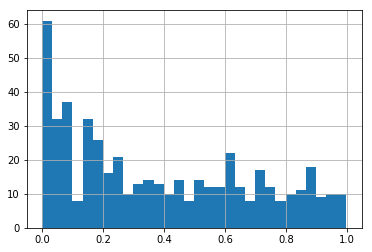

In [118]:
test_2d_result.query('tf == "STAT1"')['dc_pval'].hist(bins=30)

In [73]:
estimator.group_cells['sg^ctrl^default_rep^default_batch^CD14+ Monocytes'].shape

(3365, 35635)

In [92]:
gene_idxs_1

array([ 4857, 20895])

In [97]:
estimator.estimated_central_moments['sg^ctrl^default_rep^default_batch^CD14+ Monocytes']['first'][gene_idxs_1][:10]

array([2.95460374, 0.65657861])

In [98]:
estimator.estimated_central_moments['sg^ctrl^default_rep^default_batch^CD14+ Monocytes']['second'][gene_idxs_1][:10]

array([18.2288504 ,  4.53393143])

In [99]:
estimator.q_sq

0.005836500227251985

In [139]:
gene_idxs_2[:100]

array([28144, 28206, 28208, 28230, 28234, 28238, 28245, 28272, 28273,
       28289, 28305, 28308, 28312, 28323, 28357, 28367, 28389, 28393,
       28400, 28423, 28425, 28436, 28488, 28492, 28523, 28552, 28572,
       28583, 28592, 28593, 28601, 28608, 28612, 28613, 28622, 28624,
       28631, 28632, 28647, 28655, 28660, 28661, 28662, 28670, 28673,
       28687, 28701, 28725, 28735, 28740, 28741, 28744, 28757, 28758,
       28771, 28783, 28807, 28817, 28832, 28833, 28840, 28865, 28881,
       28893, 28895, 28923, 28925, 28928, 28933, 28942, 28946, 28949,
       28959, 28961, 28965, 28966, 28967, 28968, 28983, 28989, 28993,
       28997, 29001, 29026, 29028, 29040, 29050, 29063, 29066, 29072,
       29076, 29087, 29091, 29109, 29118, 29127, 29135, 29157, 29158,
       29159])

In [136]:
corrs = \
    estimator.parameters['sg^ctrl^default_rep^default_batch^CD14+ Monocytes']['corr']\
    [gene_idxs_1[0], gene_idxs_2].toarray().reshape(-1)

In [137]:
import pickle as pkl

In [138]:
with open('temp.pkl', 'wb') as f:
    pkl.dump(corrs, f)

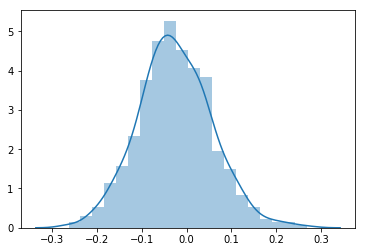

In [31]:
sns.distplot(corrs)

(array([114.,  46.,  30.,  27.,  28.,  29.,  14.,  23.,  17.,  17.,  17.,
         18.,  12.,  19.,  18.,  16.,  10.,  19.,  17.,   9.]),
 array([0.        , 0.04955504, 0.09911009, 0.14866513, 0.19822018,
        0.24777523, 0.29733026, 0.34688532, 0.39644036, 0.44599542,
        0.49555045, 0.5451055 , 0.5946605 , 0.6442156 , 0.69377065,
        0.7433257 , 0.7928807 , 0.8424358 , 0.89199084, 0.94154584,
        0.9911009 ], dtype=float32),
 <a list of 20 Patch objects>)

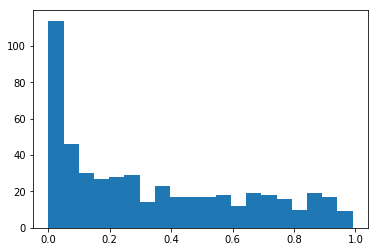

In [75]:
plt.hist(test_2d_result['dc_pval'], bins=20)

In [773]:
es_ind = estimator.compute_confidence_intervals_2d(gene_list_1, gene_list_2)

/Users/mincheolkim/Github/scrna-parameter-estimation/scmemo/mme.py:806: RuntimeWarning: invalid value encountered in sqrt
  
/Users/mincheolkim/Github/scrna-parameter-estimation/scmemo/utils.py:134: RuntimeWarning: invalid value encountered in greater
  extreme_count = (perm_diff > 0).sum()
//anaconda3/envs/single_cell/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(-2.0, 2.0)

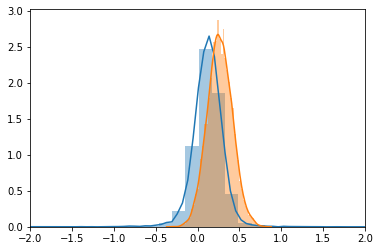

In [758]:
sns.distplot(es_ind)
sns.distplot(es)

plt.xlim(-2, 2)

In [708]:
dfs = []
for idx, tf in enumerate(['STAT1', 'STAT2']):
    test_2d_result = pd.DataFrame()
    test_2d_result['gene'] = adata.var.iloc[gene_idxs_2, :].index.tolist()
    test_2d_result['tf'] = tf

    for col in ['dc_effect_size', 'dc_pval', 'dc_fdr']:
        test_2d_result[col] = estimator.hypothesis_test_result['CD14+ Monocytes'][col][gene_idxs_1[:, np.newaxis], gene_idxs_2].toarray()[idx, :]
    dfs.append(test_2d_result)
test_2d_result = pd.concat(dfs)

In [730]:
test_2d_result_ind.query('dc_fdr < 0.1 & tf == "STAT1"').shape

(8, 5)

In [729]:
test_2d_result.query('dc_fdr < 0.1 & tf == "STAT1"').shape

(61, 5)

In [763]:
(test_2d_result['dc_effect_size'].abs() - test_2d_result_ind['dc_effect_size'].abs()).mean()

-0.0074170423

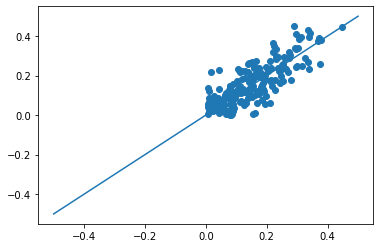

In [761]:
plt.scatter(test_2d_result['dc_effect_size'].abs(), test_2d_result_ind['dc_effect_size'].abs())
plt.plot([-0.5, 0.5], [-0.5, 0.5])

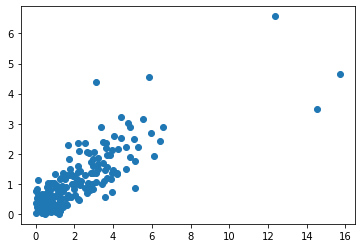

In [713]:
plt.scatter(-np.log(test_2d_result['dc_pval']), -np.log(test_2d_result_ind['dc_pval']))

In [695]:
dfs_ind = []
for idx, tf in enumerate(['STAT1', 'STAT2']):
    test_2d_result_ind = pd.DataFrame()
    test_2d_result_ind['gene'] = adata.var.iloc[gene_idxs_2, :].index.tolist()
    test_2d_result_ind['tf'] = tf

    for col in ['dc_effect_size', 'dc_pval', 'dc_fdr']:
        test_2d_result_ind[col] = estimator.hypothesis_test_result['CD14+ Monocytes'][col][gene_idxs_1[:, np.newaxis], gene_idxs_2].toarray()[idx, :]
    dfs_ind.append(test_2d_result_ind)
test_2d_result_ind = pd.concat(dfs_ind)

In [696]:
test_2d_result_ind.head(5)

,gene,tf,dc_effect_size,dc_pval,dc_fdr
0,NCOR1,STAT1,0.238636,0.493951,0.618688
1,PSMA2-1,STAT1,0.051664,0.995100,0.995100
2,MITD1,STAT1,0.061154,0.735926,0.822264
3,PDCD4,STAT1,0.239563,0.139786,0.241355
4,ZNFX1,STAT1,0.137907,0.459754,0.591323


In [651]:
group = 'sg^ctrl^1488^default_batch^CD14+ Monocytes'

In [649]:
np.isfinite(a['sg^ctrl^1488^default_batch^CD14+ Monocytes']).sum()

9912

In [652]:
np.nanmean(a[group])

-0.08439668752733395

In [653]:
estimator.parameters[group]['corr'][gene_idxs_1[:, np.newaxis], gene_idxs_2].toarray()

array([[-0.05553349],
       [        nan]], dtype=float32)

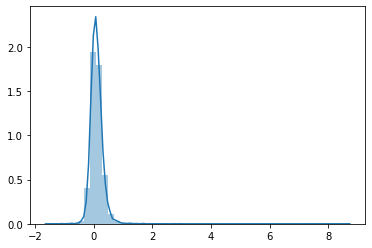

In [645]:
sns.distplot(a['sg^ctrl^1016^default_batch^CD14+ Monocytes'])

In [643]:
estimator.hypothesis_test_result['CD14+ Monocytes']['dc_effect_size'][gene_idxs_1[:, np.newaxis], gene_idxs_2].toarray()

array([[0.05452165],
       [       nan]], dtype=float32)

In [613]:
import seaborn as sns

In [ ]:
plt.hist()

In [602]:
np.nanmean(estimator.hypothesis_test_result['CD14+ Monocytes']['dc_effect_size'][gene_idxs_1[:, np.newaxis], gene_idxs_2].toarray()[0, :])

0.092377305

//anaconda3/envs/single_cell/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
//anaconda3/envs/single_cell/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([  4.,   7.,  16.,  95., 194., 272., 255., 119.,  28.,   8.]),
 array([-0.5886951 , -0.467702  , -0.34670892, -0.22571582, -0.10472272,
         0.01627037,  0.13726346,  0.25825655,  0.37924966,  0.50024277,
         0.62123585], dtype=float32),
 <a list of 10 Patch objects>)

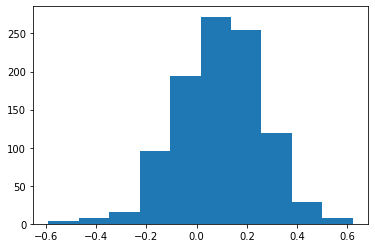

In [603]:
plt.hist(estimator.hypothesis_test_result['CD14+ Monocytes']['dc_effect_size'][gene_idxs_1[:, np.newaxis], gene_idxs_2].toarray()[0, :])

In [678]:
dfs = []
for idx, tf in enumerate(['STAT1', 'STAT2']):
    test_2d_result = pd.DataFrame()
    test_2d_result['gene'] = adata.var.iloc[gene_idxs_2, :].index.tolist()
    test_2d_result['tf'] = tf

    for col in ['dc_effect_size', 'dc_pval', 'dc_fdr']:
        test_2d_result[col] = estimator.hypothesis_test_result['CD14+ Monocytes'][col][gene_idxs_1[:, np.newaxis], gene_idxs_2].toarray()[idx, :]
    dfs.append(test_2d_result)
test_2d_result = pd.concat(dfs)

//anaconda3/envs/single_cell/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
//anaconda3/envs/single_cell/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 1.,  0.,  0.,  1.,  1.,  2.,  2.,  1.,  3.,  7., 12., 14.,  8.,
        15., 11., 17., 17., 19., 12., 19., 10.,  9.,  8.,  3.,  4.,  2.,
         0.,  1.,  0.,  1.]),
 array([-0.33754793, -0.3091513 , -0.28075466, -0.25235802, -0.2239614 ,
        -0.19556476, -0.16716813, -0.13877149, -0.11037486, -0.08197823,
        -0.0535816 , -0.02518496,  0.00321167,  0.03160831,  0.06000494,
         0.08840157,  0.11679821,  0.14519484,  0.17359146,  0.2019881 ,
         0.23038474,  0.25878137,  0.287178  ,  0.31557465,  0.34397128,
         0.37236792,  0.40076452,  0.42916116,  0.4575578 ,  0.48595443,
         0.51435107], dtype=float32),
 <a list of 30 Patch objects>)

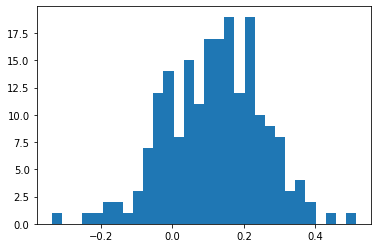

In [682]:
plt.hist(test_2d_result['dc_effect_size'], bins=30)

(array([235.,  16.,  13.,  19.,   6.,   6.,   5.,   8.,   5.,   7.,   4.,
          5.,   2.,   5.,   5.,   2.,   4.,   5.,   4.,   7.,   1.,   5.,
          6.,   1.,   2.,   4.,   4.,   4.,   4.,   6.]),
 array([0.        , 0.03327001, 0.06654001, 0.09981002, 0.13308002,
        0.16635002, 0.19962004, 0.23289004, 0.26616004, 0.29943004,
        0.33270004, 0.36597005, 0.39924008, 0.43251008, 0.46578008,
        0.49905008, 0.5323201 , 0.5655901 , 0.5988601 , 0.6321301 ,
        0.6654001 , 0.6986701 , 0.7319401 , 0.76521015, 0.79848015,
        0.83175015, 0.86502016, 0.89829016, 0.93156016, 0.96483016,
        0.99810016], dtype=float32),
 <a list of 30 Patch objects>)

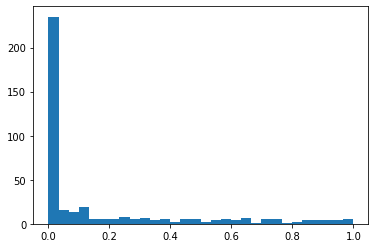

In [681]:
plt.hist(test_2d_result['dc_pval'], bins=30)

In [679]:
test_2d_result.query('tf == "STAT1" & dc_fdr < 0.1')

,gene,tf,dc_effect_size,dc_pval,dc_fdr
0,OSTC,STAT1,0.249027,0.005000,0.009389
9,BIRC3,STAT1,0.194520,0.014999,0.026783
15,C11orf58,STAT1,0.297341,0.012599,0.022803
18,ANXA2,STAT1,0.338699,0.000006,0.000011
21,NDUFS8,STAT1,0.345122,0.009399,0.017325
23,RIT1,STAT1,0.218273,0.057594,0.092894
25,OCIAD2,STAT1,0.268811,0.003200,0.006124
34,DNASE2,STAT1,-0.193883,0.059594,0.095733
39,OSBPL8,STAT1,0.225560,0.049995,0.082296
40,TMEM66,STAT1,0.248237,0.001600,0.003091


In [582]:
test_2d_result.query('tf == "STAT2" & dc_fdr < 0.1')

,gene,tf,dc_effect_size,dc_pval,dc_fdr


In [586]:
estimator.hypothesis_test_result['CD14+ Monocytes']['design_df']

,covariate,replicate,batch,constant,cell_count
0,0,1016,default_batch,1,461
1,0,1256,default_batch,1,469
2,0,1015,default_batch,1,908
3,0,107,default_batch,1,255
4,0,1244,default_batch,1,500
5,0,101,default_batch,1,247
6,0,1488,default_batch,1,365
7,0,1039,default_batch,1,160
8,1,101,default_batch,1,302
9,1,1016,default_batch,1,401


(array([299., 339., 367., 377., 436., 422., 414., 461., 432., 453.]),
 array([0.     , 0.09997, 0.19994, 0.29991, 0.39988, 0.49985, 0.59982,
        0.69979, 0.79976, 0.89973, 0.9997 ], dtype=float32),
 <a list of 10 Patch objects>)

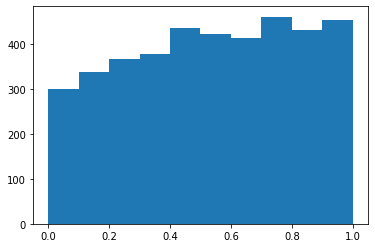

In [584]:
plt.hist(test_2d_result['dc_pval'])

In [583]:
test_2d_result.head(100)

,gene,tf,dc_effect_size,dc_pval,dc_fdr
0,B2M,STAT1,0.102194,0.940906,0.997311
1,MALAT1,STAT1,0.257830,0.064194,0.997311
2,TMSB4X,STAT1,0.238927,0.012399,0.982358
3,FTH1,STAT1,0.022244,0.929507,0.997311
4,HLA-B,STAT1,-0.083608,0.640336,0.997311
5,RPLP1,STAT1,0.144014,0.558344,0.997311
6,RPS2,STAT1,0.216442,0.031797,0.997311
7,RPL10,STAT1,0.272418,0.010199,0.982358
8,RPL13,STAT1,0.172212,0.082392,0.997311
9,RPL21,STAT1,0.156887,0.115188,0.997311
